In [1]:
import chaosode
from scipy.interpolate import CubicSpline
from scipy import integrate
import numpy as np
from matplotlib import pyplot as plt
import utils  

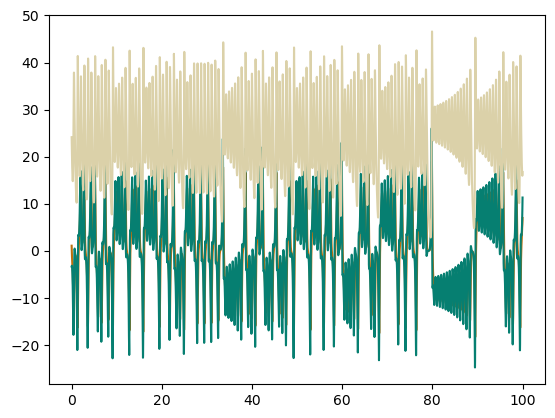

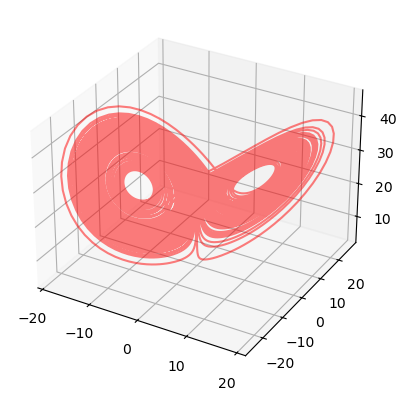

In [2]:
# Load Lorenz system data
t, U = chaosode.orbit("lorenz", duration=100)
colors = chaosode.plot2d(t, U)
_ = chaosode.plot3d(U, color="red")

# Interpolate data
u = CubicSpline(t, U) 
U_train = u(t[:9000])  # Observational data for training

#Create the true observation with multivariate normal random noise
def u0(t):
    return u(t) + np.random.multivariate_normal([0,0,0], 1e-7*np.eye(3), 1)

In [3]:
# Parameters
n = 50  # Number of reservoir nodes
gamma = 5  # Reservoir relaxation rate
sigma = 0.14  # Input scaling
mean_degree = 1
density = mean_degree / n
alpha = 1e-6  # Regularization parameter for training
nudging_strength = 0.0001  # Strength of the nudging term

In [4]:
# Directed Erdos-Renyi adjacency matrix
A = (np.random.rand(n, n) < density).astype(float)
# Fixed random matrix for input coupling
W_in = np.random.rand(n, 3) - 0.5

In [5]:
# ODE IVP definition with nudging term
def drdt_with_nudging(r, t):
    # Nudging term: relax the reservoir states toward observed data
  #  if t < t[:9000][-1]:  # Only nudge during the training period
    obs = u(t)  # Observational data
    #nudging = nudging_strength * (obs - W_out @ r)  # Relax toward observations
   # else:
    #    nudging = 0  # No nudging during prediction
    # Reservoir dynamics with nudging term
    return gamma * (-r + np.tanh(A @ r + sigma * W_in @ u(t))) #+ nudging

In [6]:
# Initial reservoir state
r0 = np.random.rand(n)

In [7]:
# Solve the reservoir dynamics with nudging during the training phase
states = integrate.odeint(drdt_with_nudging, r0, t[:9000])

In [8]:
# Training step: project training data onto reservoir states
W_out = U_train.T @ states @ np.linalg.inv(states.T @ states + alpha * np.eye(states.shape[1]))

In [9]:
W_out.shape
u0(0).shape
W_in.shape

(50, 3)

In [10]:
# Prediction ODE IVP definition (no nudging in prediction phase)
def trained_drdt(r, t):
    r = r.reshape((-1,1))
    print(np.linalg.norm(u0(t).T - W_out @ r))
    return (gamma * (-r + np.tanh(A @ r + sigma * W_in @ (W_out @ r + nudging_strength * (u0(t).T - W_out @ r))))).flatten()

# Initial state for prediction
r0_pred = states[-1, :]  # Use the final training state

In [11]:
# Solve for prediction phase
pred_states = integrate.odeint(trained_drdt, r0_pred, t[9000:])

# Map reservoir states onto the dynamical system space
U_pred = W_out @ pred_states.T

0.6640524929848034
0.6641838135388104
0.6639757542405954
0.664078141847963
0.6640055047398352
0.6641766470016229
0.6645944232358497
0.6648472135862474
0.6642709691752444
0.6646763261120956
0.6644819137952998
0.66479616875871
0.6650352685552022
0.6664199712081913
0.6668852546408164
0.6679649572060355
0.6683843398226754
0.669127714817189
0.6693236012372143
0.6788022546746456
0.6777172454591166
0.687662862282404
0.6874575254020023
0.6954328601172557
0.6956260812420761
0.7030683515931332
0.703100939789376
0.7160303599302571
0.7163530998881076
0.7277418919654238
0.7277811584503265
0.7382700745638017
0.7385075440321978
0.7476978284453129
0.7473803351904045
0.7555831173570461
0.7564915996884239
0.7656420371737312
0.7653719278694355
0.7723040264662745
0.771975343802926
0.7755762796294277
0.7762105257316196
0.776118109718718
0.7766841177719
0.7747023732513355
0.7749590740203505
0.7706462554849904
0.7704945148500818
0.7627446830913966
0.7636938410634047
0.7533706225865524
0.7537205445118622
0.74

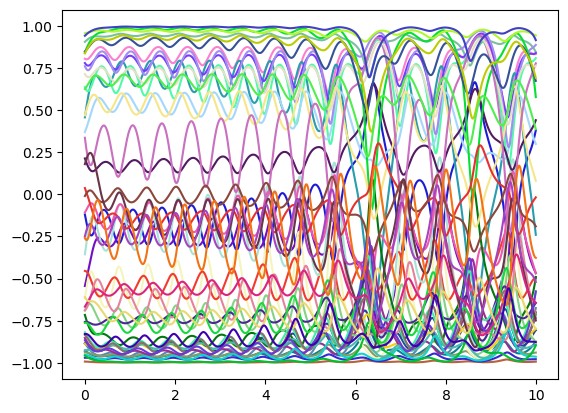

In [12]:
# Plot predictions
chaosode.plot2d(t[:1000], pred_states[:1000])
plt.show()

In [13]:
# Calculate Valid Prediction Time (VPT)
test_t = t[9000:]
vpt = utils.vpt_time(test_t, U_pred.T, u(test_t), vpt_tol=10)

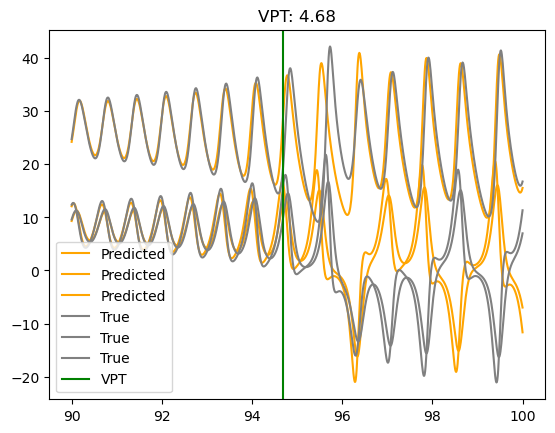

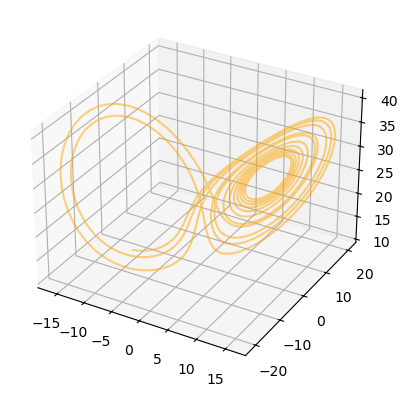

In [14]:
plt.title(f"VPT: {round(vpt,4)}")
plt.plot(test_t, U_pred.T, c="orange", label="Predicted")
plt.plot(test_t, u(test_t), c="gray", label="True")
plt.axvline(x=90 + vpt, color='green', label='VPT')
plt.legend()
plt.show()

_ = chaosode.plot3d(U_pred.T, color="orange")